In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from matplotlib import ticker
import pickle
from sklearn.metrics import make_scorer, confusion_matrix
from math import sqrt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import xgboost


font= {'family' : 'Times New Roman','fontsize': 16, 'fontweight': 'bold',}
font2= {'family' : 'Times New Roman', 'fontsize': 14, 'fontweight': 'bold'}

In [2]:
meta_df = pd.read_csv('data/metabolites_small_gapenergy_0108.csv', index_col=0)#'64' max
drug_df = pd.read_csv('data/druglike_small_gapenergy_0108.csv', index_col=0) #'48' max
tox_df = pd.read_csv('data/tox_small_gapenergy_0108.csv', index_col=0)

In [3]:
tox_df.head()

,standard_smiles,source,1,2,3,4,5,6,7,8,...,56,57,58,59,60,61,62,63,64,65
0,Clc1ccc(-c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c(Cl)c1Cl,toxic,181.555556,77.500000,128.103448,109.105263,115.611111,101.583333,80.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C=C(C)C1OC2CCC3(C)C4(C)c5[nH]c6cc(Cl)c7c8c6c5C...,toxic,57.292308,58.184848,59.786561,61.690756,65.943761,65.229703,58.216387,55.446970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Brc1cc(Br)cc(-c2ccc(Br)c(Br)c2)c1,toxic,193.777778,103.692308,141.379310,124.000000,142.444444,135.500000,101.625000,137.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C[C@]12C=CC(=O)C=C1CC[C@H]1[C@@H]3C[C@@H](O)[C...,toxic,63.660714,68.740933,69.186207,68.838509,69.780669,73.088889,103.395161,86.705882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,toxic,118.756098,70.789474,100.314961,81.912281,79.085714,80.926829,90.070588,78.113636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SpearmanrResult(correlation=-0.9362179487179487, pvalue=7.462760597426328e-30)
SpearmanrResult(correlation=-0.9767694311767261, pvalue=2.015298198608669e-32)


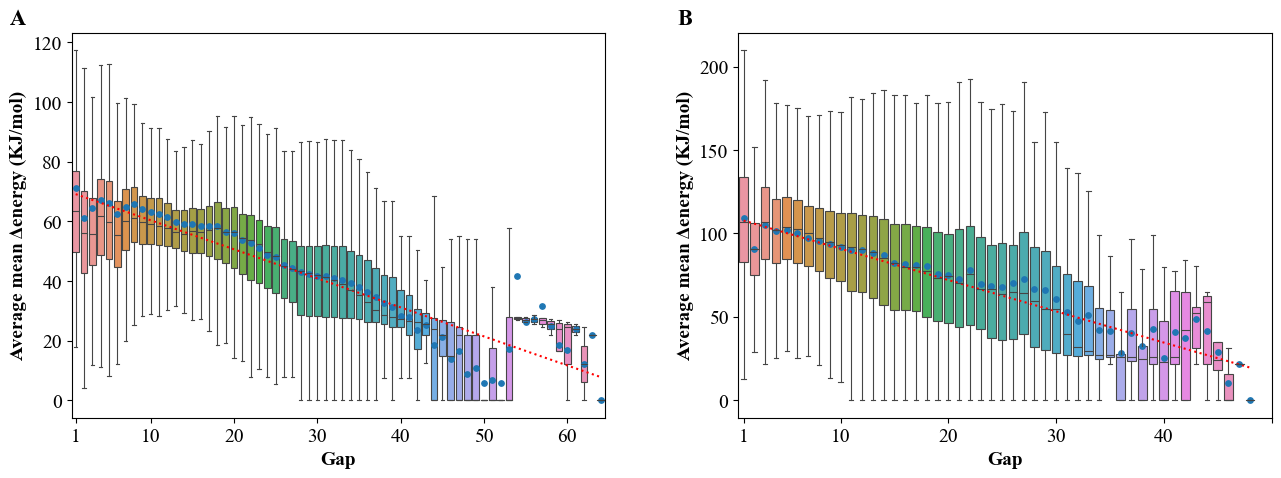

In [29]:
plt.rcParams['figure.figsize']=(15,5)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
f, ((ax1, ax2)) = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3)
sn.boxplot(data=meta_df.iloc[:,4:68],sym='',ax=ax1, linewidth=0.8)
ax1.tick_params(axis='x', labelsize= 14)
ax1.tick_params(axis='y', labelsize= 14)
ax1.set_xticks([0, 9, 19, 29, 39, 49, 59])
# ax1.set_xlabel('Gap', fontdict=font2)
# ax1.set_ylabel('Mean Δenergy (KJ/mol)', fontdict=font2)
ax1.set_title('A',fontdict=font,x = -0.1)

sn.boxplot(data=drug_df.iloc[:,2:50],sym='', ax=ax2, linewidth=0.8)
ax2.tick_params(axis='x', labelsize= 14)
ax2.tick_params(axis='y', labelsize= 14)
ax2.set_xticks([0, 9, 19, 29, 39,49 ])
# ax2.set_xlabel('Gap', fontdict=font2)
# ax2.set_ylabel('Mean Δenergy (KJ/mol)', fontdict=font2)
ax2.set_title('B',fontdict=font,x = -0.1) #loc='left'

x_meta = [i for i in range(64)]
y_meta = np.nanmean(meta_df.iloc[:,4:68], axis=0)
slope, intercept, _, _, _ = stats.linregress(x_meta,y_meta)
rho_p = stats.spearmanr(x_meta, y_meta)
print(rho_p)
ax1.scatter(x_meta,y_meta , s= 15)
yreg = [ slope*(i+1)+ intercept for i in range(64)]
ax1.plot(x_meta, yreg,color='red',linestyle=':')
ax1.set_xticks([0, 9, 19, 29, 39, 49, 59])
ax1.set_xlabel('Gap', fontdict=font2)
ax1.set_ylabel('Average mean Δenergy (KJ/mol)', fontdict=font2)
# ax1.set_title('C',fontdict=font,x = -0.1)
# ax1.text(48,65, 'Rho = -0.936',fontsize='10')
# ax1.text(48,60,'P-value = 7.46e-30',fontsize='10')

x_drug = [i for i in range(48)]
y_drug = np.nanmean(drug_df.iloc[:,2:50], axis=0)
slope, intercept, _, _, _ = stats.linregress(x_drug,y_drug)
rho_p = stats.spearmanr(x_drug, y_drug)
print(rho_p)
ax2.scatter(x_drug, y_drug , s= 15)
yreg = [ slope*(i+1)+ intercept for i in range(48)]
ax2.plot(x_drug, yreg,color='red',linestyle=':')
ax2.set_xticks([0, 9, 19, 29, 39, 49 ])
ax2.set_xlabel('Gap', fontdict=font2)
ax2.set_ylabel('Average mean Δenergy (KJ/mol)', fontdict=font2)
# ax2.set_title('D',fontdict=font,x = -0.1)
# ax2.text(36,99, 'Rho = -0.977',fontsize='10')
# ax2.text(36,92,'P-value = 2.02e-32',fontsize='10')
plt.savefig('箱线图和均值图.tif', dpi=400)

plt.show()

In [6]:
per_meta = meta_df.iloc[:,4:68].count(axis=0)/len(meta_df.index)
print(str(100*per_meta[9])+'%')
per_drug = drug_df.iloc[:,2:50].count(axis=0)/len(drug_df.index)
print(str(100*per_drug[9])+'%')

90.25114458231039%
74.5933764452283%


In [7]:
meta_maxgap= list(meta_df.iloc[:,4:68].count(axis=1))
meta_nummaxgap = np.array([meta_maxgap.count(i+1) for i in range(64)])
drug_maxgap= list(drug_df.iloc[:,2:50].count(axis=1))
drug_nummaxgap = np.array([drug_maxgap.count(i+1) for i in range(48)])

per_meta = meta_nummaxgap/len(meta_df.index)
per_drug = drug_nummaxgap/len(drug_df.index)

sum_meta = sum(per_meta[:45])
sum_drug = sum(per_drug[:20])
print(sum_meta)
print(sum_drug)

0.8701894366664454
0.9240642759161276


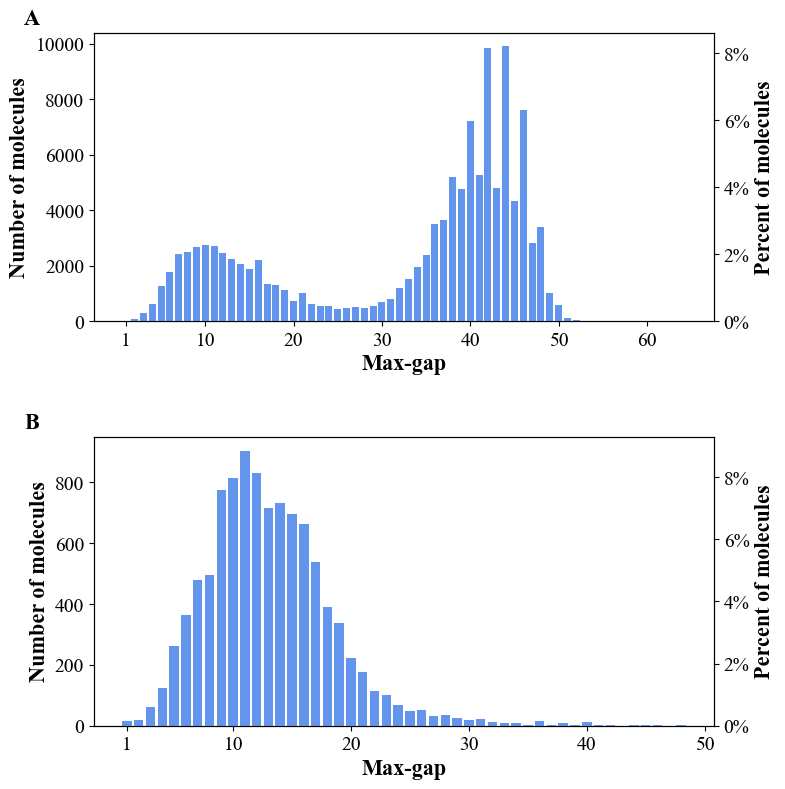

In [47]:
plt.rcParams['figure.figsize']=(8,9)
f, (ax1,ax2) = plt.subplots(2,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
ax1.bar([i+1 for i in range(64)], meta_nummaxgap, color='cornflowerblue') #meta_df.iloc[:,4:68].count(axis=0)
ax1.tick_params(axis='x', labelsize= 14)
ax1.tick_params(axis='y', labelsize= 14)
ax1.set_xlabel('Max-gap', fontdict=font)
ax1.set_ylabel('Number of molecules', fontdict=font)
ax1.set_xticks([1, 10, 20, 30, 40, 50,60])
ax3=ax1.twinx()
ax3.tick_params(axis='x', labelsize= 14)
ax3.tick_params(axis='y', labelsize= 14)
ax3.bar([i+1 for i in range(64)], per_meta, color='cornflowerblue')
ax3.set_ylabel('Percent of molecules', fontdict=font)
ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax1.set_title('A',fontdict=font,x=-0.1)

ax2.bar([i+1 for i in range(48)], drug_nummaxgap, color='cornflowerblue') #drug_df.iloc[:,2:50].count(axis=0)
ax2.tick_params(axis='x', labelsize= 14)
ax2.tick_params(axis='y', labelsize= 14)
ax2.set_xticks([1, 10, 20, 30, 40, 50])
ax2.set_xlabel('Max-gap', fontdict=font)
ax2.set_ylabel('Number of molecules', fontdict=font)
ax2.set_title('B',fontdict=font,x=-0.1)
ax4=ax2.twinx()
ax4.tick_params(axis='x', labelsize= 14)
ax4.tick_params(axis='y', labelsize= 14)
ax4.bar([i+1 for i in range(48)], per_drug, color='cornflowerblue')
ax4.set_ylabel('Percent of molecules', fontdict=font)
ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

plt.savefig('gap-分子数图.tif',dpi=400)
plt.show()


['None', 'Endogenous', 'Food', 'Biological', 'Environmental', 'Synthetic']


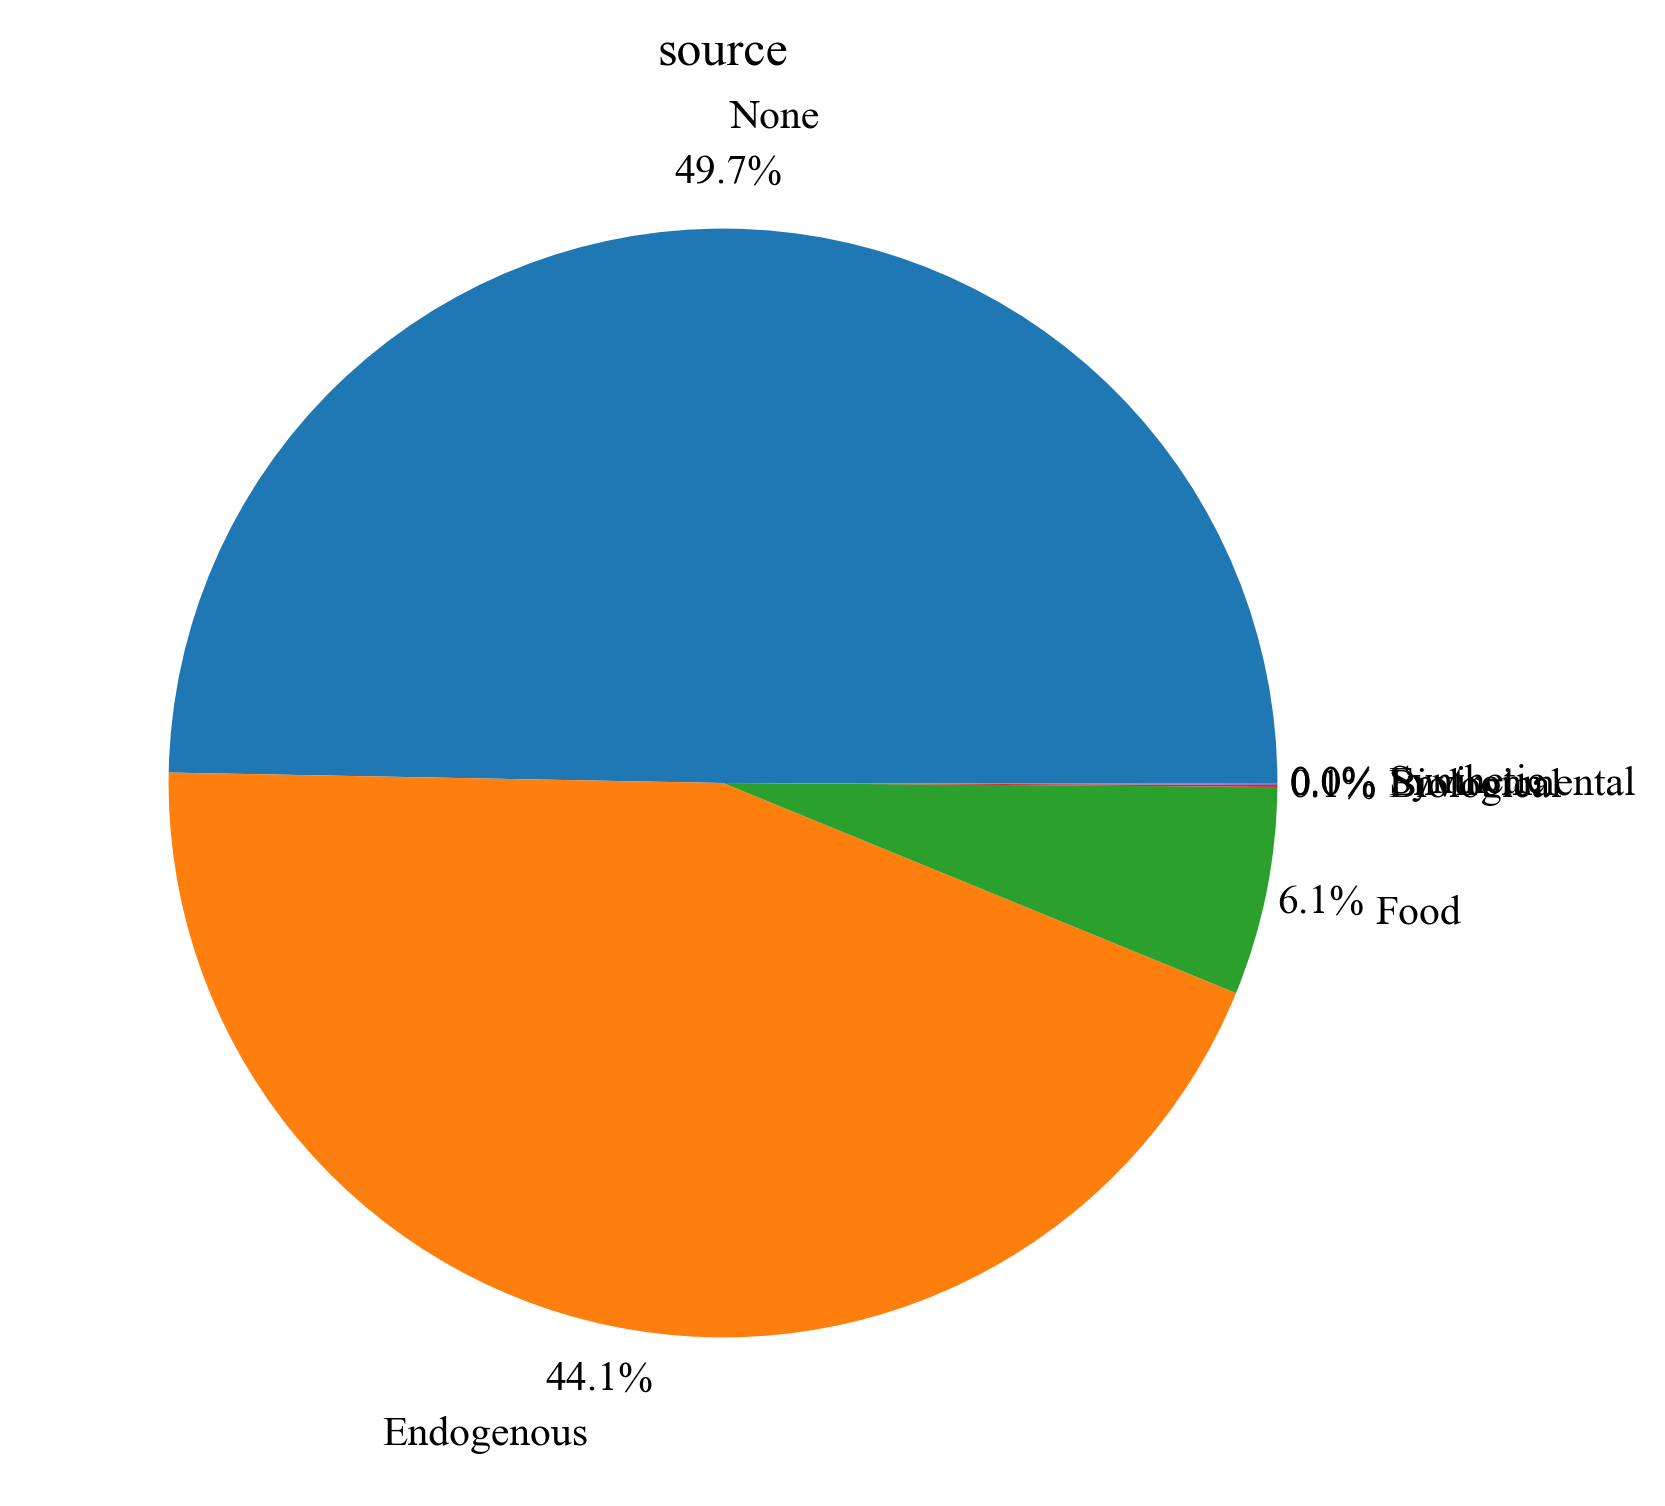

In [9]:
key = 'source'
import matplotlib.pylab as plt
def draw_pie(key,df):
        grades_labels = list(df[key].value_counts().index)
        print(grades_labels)
        grades_nums = df[key].value_counts().values
        plt.figure(figsize=(12,6),dpi=300)
        plt.pie(grades_nums, labels = grades_labels, autopct = '%1.1f%%',
        pctdistance = 1.1,labeldistance = 1.2)
        plt.title(key)
        plt.show()
draw_pie(key, meta_df)

In [10]:
exo_df = meta_df[(meta_df['source'] != 'None')&(meta_df['source'] != 'Endogenous')]#4:52
endo_df = meta_df[meta_df['source'] == 'Endogenous']#4:66
# print(exo_df.iloc[:,51].info()) 
# print(endo_df.iloc[:,65].info()) 
app_df = drug_df[drug_df['source']== 'approved']#2:48
unapp_df = drug_df[drug_df['source']!= 'approved']#2:50
print('app',app_df.iloc[:,48].info()) 
print('unapp',unapp_df.iloc[:,50].info()) 
# print('tox',tox_df.iloc[:,35].info()) #2:36

<class 'pandas.core.series.Series'>
Int64Index: 2171 entries, 0 to 2170
Series name: 47
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 33.9 KB
app None
<class 'pandas.core.series.Series'>
Int64Index: 8035 entries, 2171 to 10205
Series name: 49
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 125.5 KB
unapp None


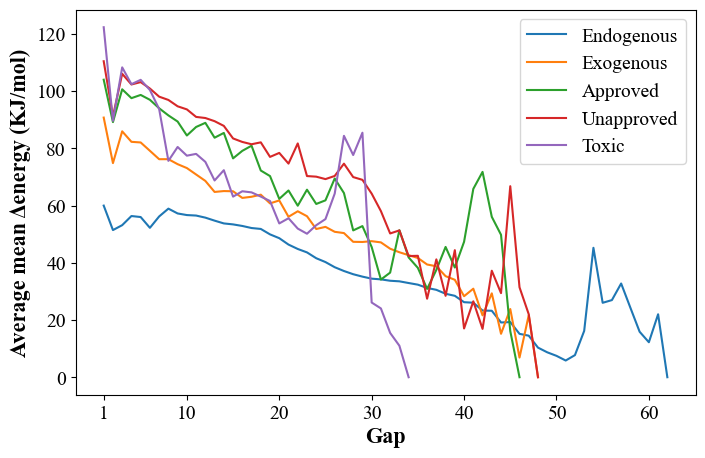

In [39]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
f, ax = plt.subplots()
ax.plot([i+1 for i in range(62)], np.nanmean(endo_df.iloc[:, 4:66], axis=0), label='Endogenous')
ax.plot([i+1 for i in range(48)], np.nanmean(exo_df.iloc[:, 4:52], axis=0), label='Exogenous')
ax.plot([i+1 for i in range(46)], np.nanmean(app_df.iloc[:, 2:48], axis=0),label='Approved')
ax.plot([i+1 for i in range(48)], np.nanmean(unapp_df.iloc[:, 2:50], axis=0),label='Unapproved')
ax.plot([i+1 for i in range(34)], np.nanmean(tox_df.iloc[:, 2:36], axis=0), label='Toxic')
ax.tick_params(axis='x', labelsize= 14)
ax.tick_params(axis='y', labelsize= 14)
plt.xlabel('Gap', fontdict=font)
plt.ylabel('Average mean Δenergy (KJ/mol)', fontdict=font)
plt.xticks([1, 10, 20, 30, 40, 50,60])
# ax1.set_title('A',fontsize=10,loc='left')
plt.legend(loc='upper right', prop={'size':14})
plt.savefig('不同类分子对比图.tif',dpi=400)
plt.show()


In [48]:
# Kruskal-Wallis 单因素方差分析
# Mann-Whitney U检验

def KKW_MWUtest(endo_df=endo_df, exo_df=exo_df, app_df=app_df, unapp_df=unapp_df, tox_df=tox_df):
    res = {'gap':[], 'p_value_all':[], 'p_value_endo_exo':[], 'p_value_app_unapp':[], 'p_value_exo_tox':[]}
    for i in range(30):
        endo_df1 = endo_df.iloc[:, 4+i].dropna()
        exo_df1 = exo_df.iloc[:, 4+i].dropna()
        app_df1 = app_df.iloc[:, 2+i].dropna()
        unapp_df1 = unapp_df.iloc[:, 2+i].dropna()
        tox_df1 = tox_df.iloc[:, 2+i].dropna()
        stat, p_all = stats.kruskal(endo_df1, exo_df1, app_df1, unapp_df1, tox_df1)
        stat, p_endo_exo = stats.mannwhitneyu(endo_df1, exo_df1)
        stat, p_app_unapp = stats.mannwhitneyu(app_df1, unapp_df1)
        stat, p_exo_tox = stats.mannwhitneyu(exo_df1, tox_df1)
        res['gap'].append(str(i+1))
        res['p_value_all'].append(p_all)
        res['p_value_endo_exo'].append(p_endo_exo)
        res['p_value_app_unapp'].append(p_app_unapp)
        res['p_value_exo_tox'].append(p_exo_tox)

    return res


res_kkw_mwu = KKW_MWUtest()
res_kkw_mwu = pd.DataFrame(res_kkw_mwu)
res_kkw_mwu.to_csv('res_kkw_mwu0109.csv')
res_kkw_mwu.head(30)

,gap,p_value_all,p_value_endo_exo,p_value_app_unapp,p_value_exo_tox
0,1,0.000000e+00,0.000000e+00,3.289277e-13,3.726361e-166
1,2,0.000000e+00,0.000000e+00,5.315874e-07,1.186538e-124
2,3,0.000000e+00,0.000000e+00,6.363641e-15,6.820159e-167
3,4,0.000000e+00,0.000000e+00,2.152607e-13,1.367564e-162
4,5,0.000000e+00,0.000000e+00,1.455837e-11,3.012825e-174
5,6,0.000000e+00,0.000000e+00,5.316680e-12,3.290727e-147
6,7,0.000000e+00,0.000000e+00,1.027672e-14,5.951864e-97
7,8,0.000000e+00,0.000000e+00,5.991479e-18,5.915614e-01
8,9,0.000000e+00,0.000000e+00,1.650238e-13,2.462361e-05
9,10,0.000000e+00,0.000000e+00,1.728448e-21,6.912226e-04


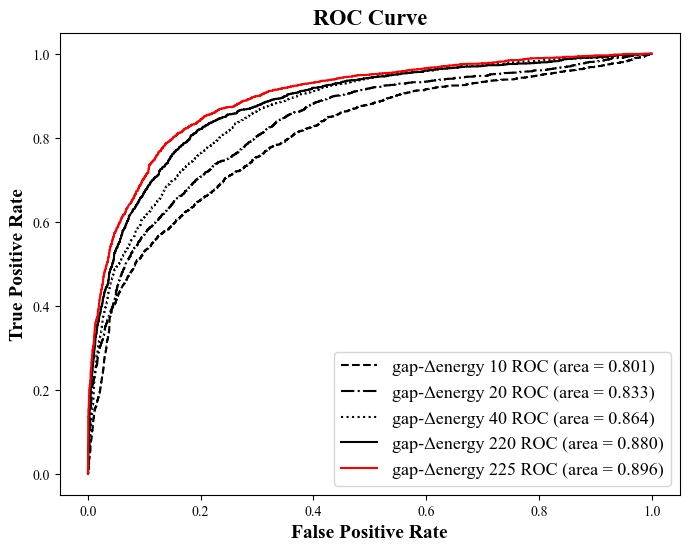

In [8]:
#SVM基线测试
#加载C:\崔庆华组\1.项目：分子毒性预测\230107结果重做\jixian_res_proba.pkl
with open('results/SVM_baseline_res_proba.pkl', 'rb') as f:
    jixian_res_proba = pickle.load(f)
with open('results/SVM_baseline_y_train_truelable.pkl', 'rb') as f:
    jixian_y_train = pickle.load(f)
xian = ['k--','k-.', 'k:', 'k-','r-']
labels_feature = ['gap-Δenergy 10', 'gap-Δenergy 20', 'gap-Δenergy 40', 'gap-Δenergy 220', 'gap-Δenergy 225']
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.figsize'] = (8, 6)
for i in range(len(jixian_res_proba)):
    fpr, tpr, thersholds = roc_curve(jixian_y_train, jixian_res_proba[i][:,1])
    roc_auc = auc(fpr, tpr)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.plot(fpr, tpr, xian[i], markersize=0.5, label='{obj} ROC (area = {obj2:.3f})'.format(obj=labels_feature[i], obj2=roc_auc))
plt.xlabel('False Positive Rate', fontdict=font2)
plt.ylabel('True Positive Rate', fontdict=font2)
plt.title('ROC Curve', fontdict=font)
legend_font = {
    'family': 'Times New Roman',  # 字体
    'size': 13,  # 字号
}
plt.legend(loc="lower right", prop=legend_font)
plt.savefig('不同特征数量的SVM基线ROC.tif', dpi=400)
plt.show()

In [49]:
df_test_merics = pd.read_csv('results/all_res_test_0124.csv', index_col = 0)
# print(df_test_merics)
labels = df_test_merics.columns.to_list()
# print(labels)

df_test_merics =df_test_merics.reset_index()
df_test_merics

,features,method,test_acc,test_ba,test_f1,test_auc,test_mcc,test_sn,test_sp
0,descri,KNN,0.903275,0.867705,0.811189,0.920889,0.746576,0.792969,0.942441
1,descri,LGBM,0.916581,0.891206,0.840353,0.964106,0.783899,0.837891,0.944521
2,descri,MLP,0.910440,0.873189,0.823054,0.952322,0.764059,0.794922,0.951456
3,descri,RF,0.914023,0.889472,0.836257,0.964190,0.777967,0.837891,0.941054
4,descri,SVM,0.901740,0.895007,0.824497,0.952484,0.759650,0.880859,0.909154
5,descri,XGB,0.917605,0.892529,0.842311,0.964454,0.786551,0.839844,0.945215
6,gapen_all,KNN,0.848004,0.782390,0.689655,0.858720,0.592206,0.644531,0.920250
7,gapen_all,LGBM,0.867963,0.838741,0.755218,0.932956,0.665424,0.777344,0.900139
8,gapen_all,MLP,0.856192,0.809352,0.721506,0.888553,0.624731,0.710938,0.907767
9,gapen_all,RF,0.848516,0.799113,0.706349,0.904269,0.604453,0.695312,0.902913


In [50]:
def metrics(str_features):
    KNN_m = df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='KNN')]\
                        .drop(['features','method'], axis=1).values.flatten()
    LGBM_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='LGBM')]\
                        .drop(['features','method'], axis=1).values.flatten()
    MLP_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='MLP')]\
                        .drop(['features','method'], axis=1).values.flatten()
    RF_m = df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='RF')]\
                        .drop(['features','method'], axis=1).values.flatten()
    SVM_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='SVM')]\
                        .drop(['features','method'], axis=1).values.flatten()
    XGB_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='XGB')]\
                        .drop(['features','method'], axis=1).values.flatten()
    return KNN_m, LGBM_m, MLP_m, RF_m, SVM_m, XGB_m

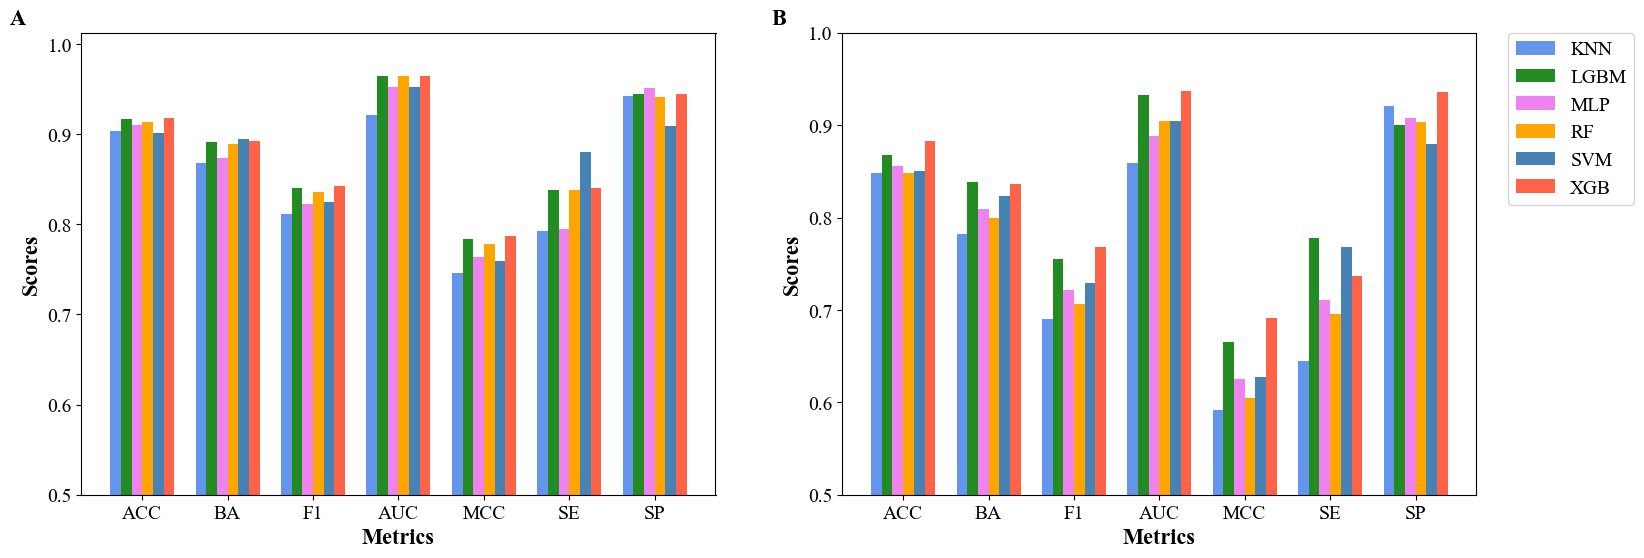

In [53]:
labels = ['ACC', 'BA', 'F1', 'AUC', 'MCC', 'SE', 'SP']
x=np.arange(len(labels))
x*=2
width = 0.25
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig,(ax1, ax2)  = plt.subplots(1,2) #, ax3
# plt.subplots_adjust(left=0.1, bottom=0, right=None, top=None, wspace=None, hspace=None)
KNN_m, LGBM_m, MLP_m, RF_m, SVM_m, XGB_m = metrics('descri')
ax1.set_title('A',fontdict=font,x=-0.1)
ax1.tick_params(axis='x', labelsize= 14)
ax1.tick_params(axis='y', labelsize= 14)
ax1.bar(x-0.625, KNN_m,width,label='KNN', color =['cornflowerblue'])
ax1.bar(x-0.375,LGBM_m,width,label='LGBM', color =['forestgreen'])
ax1.bar(x-0.125,MLP_m,width,label='MLP', color =['violet'])
ax1.bar(x+0.125, RF_m,width,label='RF', color =['orange'])
ax1.bar(x+0.375,SVM_m,width,label='SVM', color =['steelblue'])
ax1.bar(x+0.625,XGB_m,width,label='XGB', color =['tomato'])

ax1.set_xlabel('Metrics', fontdict = font)
ax1.set_ylabel('Scores', fontdict = font)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0.5)
ax1.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
# ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

KNN_m, LGBM_m, MLP_m, RF_m, SVM_m, XGB_m = metrics('gapen_all')
ax2.set_title('B',fontdict=font,x=-0.1)
ax2.tick_params(axis='x', labelsize= 14)
ax2.tick_params(axis='y', labelsize= 14)
ax2.bar(x-0.625, KNN_m,width,label='KNN', color =['cornflowerblue'])
ax2.bar(x-0.375,LGBM_m,width,label='LGBM', color =['forestgreen'])
ax2.bar(x-0.125,MLP_m,width,label='MLP', color =['violet'])
ax2.bar(x+0.125, RF_m,width,label='RF', color =['orange'])
ax2.bar(x+0.375,SVM_m,width,label='SVM', color =['steelblue'])
ax2.bar(x+0.625,XGB_m,width,label='XGB', color =['tomato'])

ax2.set_xlabel('Metrics', fontdict = font)
ax2.set_ylabel('Scores', fontdict = font)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylim(0.5)
ax2.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size':14})

# KNN_m, LGBM_m, MLP_m, RF_m, SVM_m, XGB_m = metrics('gapen_all+descri')
# ax3.set_title('C',fontdict=font,x=-0.1)
# ax3.bar(x-0.625, KNN_m,width,label='KNN', color =['cornflowerblue'])
# ax3.bar(x-0.375,LGBM_m,width,label='LGBM', color =['forestgreen'])
# ax3.bar(x-0.125,MLP_m,width,label='MLP', color =['violet'])
# ax3.bar(x+0.125, RF_m,width,label='RF', color =['orange'])
# ax3.bar(x+0.375,SVM_m,width,label='SVM', color =['steelblue'])
# ax3.bar(x+0.625,XGB_m,width,label='XGB', color =['tomato'])

# ax3.set_xlabel('Metrics', fontdict = font2)
# ax3.set_ylabel('Scores', fontdict = font2)
# ax3.set_xticks(x)
# ax3.set_xticklabels(labels)
# ax3.set_ylim(0.5)
# ax3.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
# ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

plt.savefig('各分类器性能.tif', dpi = 400)
plt.show()

In [54]:
df_xiaorong = pd.read_csv('results/jixian_xiaorong_0106.csv',index_col=0)
df_xiaorong.columns = ['BA_score']
df_xiaorong.index = ['gapen_10', 'gapen_20', 'gapen_40', 'gapen_220', 'gapen_225']

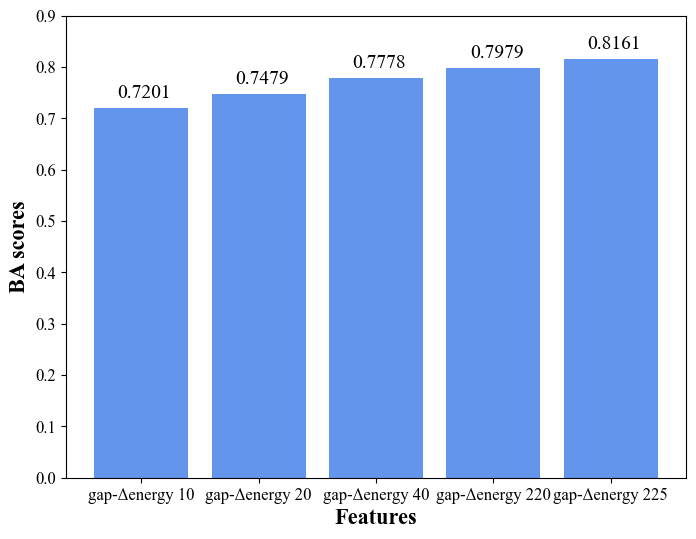

In [58]:
labels = ['gap-Δenergy 10', 'gap-Δenergy 20', 'gap-Δenergy 40', 'gap-Δenergy 220', 'gap-Δenergy 225']
x=np.arange(len(labels))
width = 0.8
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig,ax  = plt.subplots()
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)
ax.bar(x, df_xiaorong['BA_score'],width, color =['cornflowerblue'])
ax.set_xlabel('Features', fontdict = font)
ax.set_ylabel('BA scores', fontdict = font)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yticks([ 0.0, 0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9])
for x, y in enumerate(df_xiaorong['BA_score'].values):
    plt.text(x-0.2, y+0.02, round(y,4),fontdict={'size':14})
plt.savefig('特征工程与消融实验.tif', dpi = 1000)
plt.show()

In [59]:
#特征筛选
xgb_gapen_selector = pd.read_csv('results/xgb_gapen_valba_selector.csv', index_col=0)
xgb_descri_selector = pd.read_csv('results/xgb_descri_valba_selector.csv', index_col=0)
lgbm_gapen_selector = pd.read_csv('results/lgbm_gapen_valba_selector.csv', index_col=0)
lgbm_descri_selector = pd.read_csv('results/lgbm_descri_valba_selector.csv', index_col=0)

In [60]:
xgb_gapen_selector['val_ba'].idxmax()
idxmax= xgb_gapen_selector['val_ba'].idxmax()
xgb_gapen_selector['val_ba'][idxmax]
xgb_gapen_selector['feature_num'][idxmax]

50

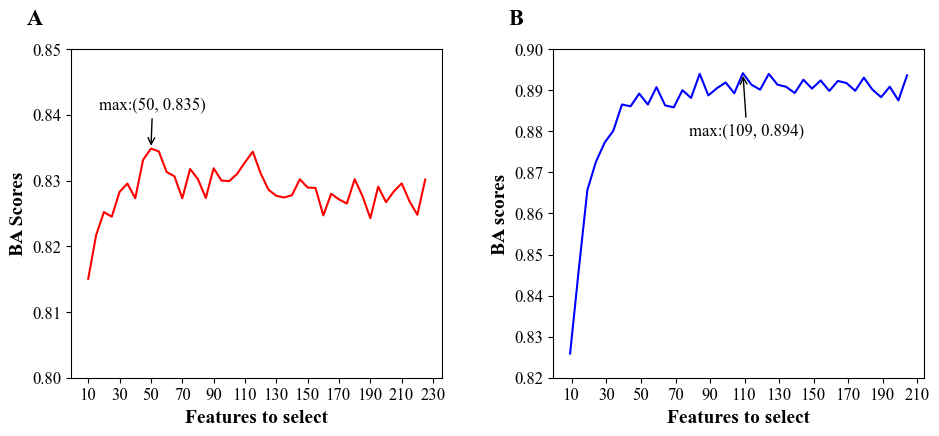

In [122]:
plt.rcParams['figure.figsize'] = (11, 4.5)
plt.rcParams['font.sans-serif'] = ['Times New Roman']
f, ([ax1,ax2]) = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=None, wspace=0.3, hspace=None)
ax1.tick_params(axis='x', labelsize= 12)
ax1.tick_params(axis='y', labelsize= 12)
ax1.plot(xgb_gapen_selector['feature_num'],xgb_gapen_selector['val_ba'],color='red')
ax1.set_xticks(range(10,240,20))
ax1.set_yticks([0.80,0.81,0.82,0.83,0.84,0.85])
ax1.set_xlabel('Features to select', fontdict = font2)
ax1.set_ylabel('BA Scores', fontdict = font2)
ax1.set_title('A',x=-0.1,y=1.05, fontdict = font)
idxmax= xgb_gapen_selector['val_ba'].idxmax()
y_max = xgb_gapen_selector['val_ba'][idxmax]
x_max = xgb_gapen_selector['feature_num'][idxmax]
ax1.annotate('max:'+str((x_max, round(y_max,3))), xy=(x_max, y_max), xytext = (x_max-33, y_max+0.006), arrowprops=dict(arrowstyle='->'), fontsize=12)

ax2.tick_params(axis='x', labelsize= 12)
ax2.tick_params(axis='y', labelsize= 12)
ax2.plot(xgb_descri_selector['feature_num'],xgb_descri_selector['val_ba'],color='blue')
ax2.set_xticks(range(10,230,20))
ax2.set_yticks([0.82,0.83,0.84,0.85, 0.86,0.87,0.88,0.89,0.90])
ax2.set_xlabel('Features to select', fontdict = font2)
ax2.set_ylabel('BA scores', fontdict = font2)
ax2.set_title('B',x=-0.1,y=1.05, fontdict = font)
idxmax= xgb_descri_selector['val_ba'].idxmax()
y_max = xgb_descri_selector['val_ba'][idxmax]
x_max = xgb_descri_selector['feature_num'][idxmax]
ax2.annotate('max:'+str((x_max, round(y_max,3))), xy=(x_max, y_max), xytext = (x_max-31, y_max-0.015), arrowprops=dict(arrowstyle='->'), fontsize=12)

# ax3.plot(lgbm_gapen_selector['feature_num'],lgbm_gapen_selector['val_ba'],color='red')
# ax3.set_xticks(range(10,240,20))
# ax3.set_yticks([0.80,0.81,0.82,0.83,0.84,0.85])
# ax3.set_xlabel('Features_to_select', fontdict = font2)
# ax3.set_ylabel('BA_scores', fontdict = font2)
# ax3.set_title('C',x=-0.1, fontdict = font)
# idxmax= lgbm_gapen_selector['val_ba'].idxmax()
# y_max = lgbm_gapen_selector['val_ba'][idxmax]
# x_max = lgbm_gapen_selector['feature_num'][idxmax]
# ax3.annotate('max:'+str((x_max, round(y_max,3))), xy=(x_max, y_max), xytext = (x_max-25, y_max+0.006), arrowprops=dict(arrowstyle='->'))

# ax4.plot(lgbm_descri_selector['feature_num'],lgbm_descri_selector['val_ba'],color='blue')
# ax4.set_xticks(range(10,230,20))
# ax4.set_yticks([0.82,0.83,0.84,0.85, 0.86,0.87,0.88,0.89,0.90])
# ax4.set_xlabel('Features_to_select', fontdict = font2)
# ax4.set_ylabel('BA_scores', fontdict = font2)
# ax4.set_title('D',x=-0.1, fontdict = font)
# idxmax= lgbm_descri_selector['val_ba'].idxmax()
# y_max = lgbm_descri_selector['val_ba'][idxmax]
# x_max = lgbm_descri_selector['feature_num'][idxmax]
# ax4.annotate('max:'+str((x_max, round(y_max,3))), xy=(x_max, y_max), xytext = (x_max-25, y_max-0.015), arrowprops=dict(arrowstyle='->'))

plt.savefig('特征消除.tif', dpi = 400)
plt.show()

In [10]:
# 特征消除前后
def metrics_before_after(df_test_merics, str_features):
    LGBM_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='LGBM')]\
                        .drop(['features','method'], axis=1).values.flatten()
    XGB_m= df_test_merics[(df_test_merics['features']==str_features) & (df_test_merics['method']=='XGB')]\
                        .drop(['features','method'], axis=1).values.flatten()
    return  LGBM_m, XGB_m

df_afterselect = pd.read_csv('results/selected_xgblgbm_test_0124.csv', index_col=0).reset_index()
# print(df_afterselect)


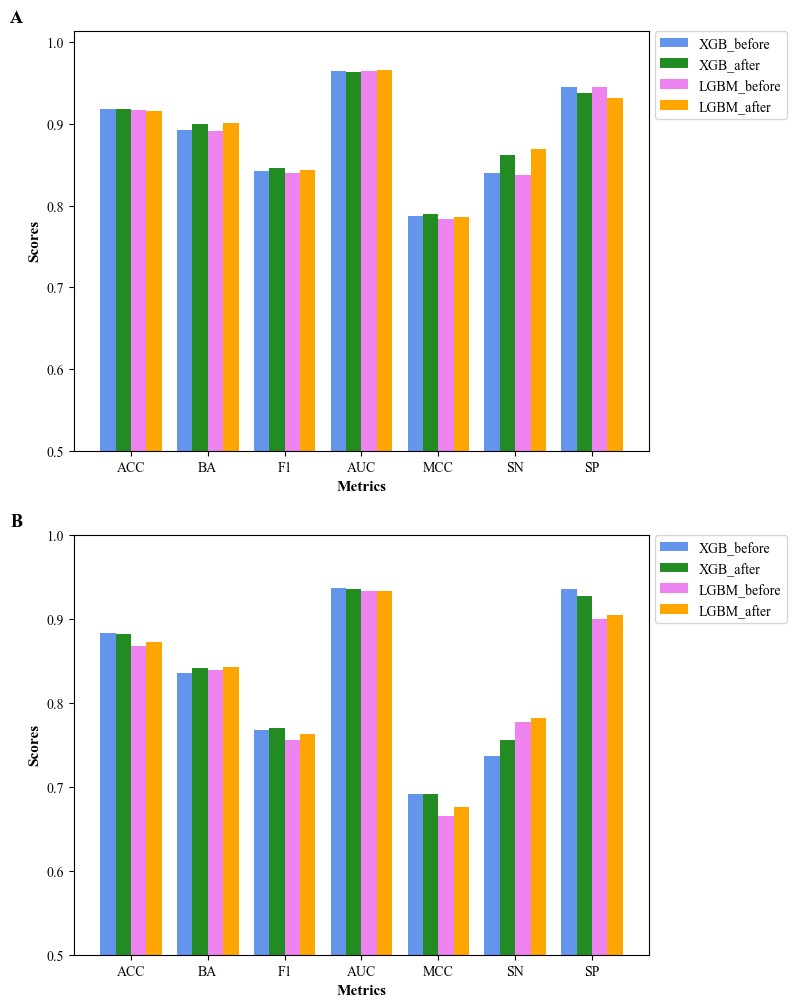

In [31]:
labels = ['ACC', 'BA', 'F1', 'AUC', 'MCC', 'SE', 'SP']
x=np.arange(len(labels))
width = 0.2
plt.rcParams['figure.figsize'] = (10, 12)
fig,(ax1, ax2)  = plt.subplots(2,1)
plt.subplots_adjust(left=None, bottom=None, right=0.7, top=None, wspace=None, hspace=None)
LGBM_m_before, XGB_m_before = metrics_before_after(df_test_merics, 'descri')
LGBM_m_after, XGB_m_after= metrics_before_after(df_afterselect, 'descri_w')
ax1.set_title('A',fontdict=font,x=-0.1)
ax1.bar(x-0.3, XGB_m_before,width,label='XGB_before', color =['cornflowerblue'])
ax1.bar(x-0.1, XGB_m_after,width,label='XGB_after', color =['forestgreen'])
ax1.bar(x+0.1, LGBM_m_before, width,label='LGBM_before', color =['violet'])
ax1.bar(x+0.3, LGBM_m_after, width,label='LGBM_after',color =['orange'])

ax1.set_xlabel('Metrics', fontdict = font2)
ax1.set_ylabel('Scores', fontdict = font2)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0.5)
ax1.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

LGBM_m_before, XGB_m_before = metrics_before_after(df_test_merics, 'gapen_all')
LGBM_m_after, XGB_m_after= metrics_before_after(df_afterselect, 'gapen_w')
ax2.set_title('B',fontdict=font,x=-0.1)
ax2.bar(x-0.3, XGB_m_before,width,label='XGB_before', color =['cornflowerblue'])
ax2.bar(x-0.1, XGB_m_after,width,label='XGB_after',  color =['forestgreen'])
ax2.bar(x+0.1, LGBM_m_before, width,label='LGBM_before',color =['violet'])
ax2.bar(x+0.3, LGBM_m_after, width,label='LGBM_after', color =['orange'])

ax2.set_xlabel('Metrics', fontdict = font2)
ax2.set_ylabel('Scores', fontdict = font2)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylim(0.5)
ax2.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

plt.savefig('特征选择后和选择前.tif', dpi = 400)
plt.show()

In [11]:
#stacking特征融合
df_LR = pd.read_csv('results/LR_finalproba_0107.csv', index_col=0)
df_LR.head()

,test_acc,test_ba,test_f1,test_auc,test_mcc,test_sn,test_sp
xgb_all,0.916581,0.908841,0.848654,0.964786,0.793098,0.892578,0.925104
lgbm_all,0.904299,0.903039,0.831380,0.964175,0.769515,0.900391,0.905687


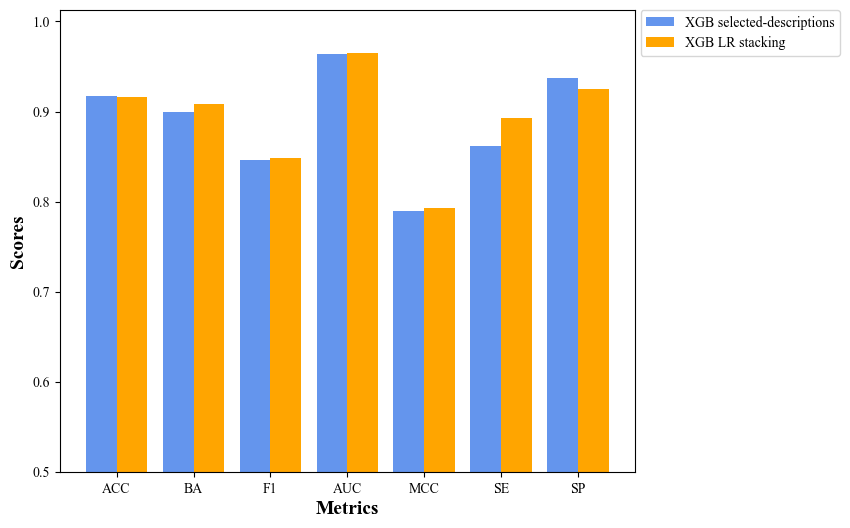

In [14]:
labels = ['ACC', 'BA', 'F1', 'AUC', 'MCC', 'SE', 'SP']
x=np.arange(len(labels))
width = 0.4
plt.rcParams['figure.figsize'] = (10, 6)
fig,(ax1)  = plt.subplots(1,)
plt.subplots_adjust(left=None, bottom=None, right=0.7, top=None, wspace=None, hspace=None)
# LGBM_m_before, XGB_m_before = metrics_before_after(df_test_merics, 'descri')
LGBM_m_after, XGB_m_after= metrics_before_after(df_afterselect, 'descri_w')
XGB_m_stacking, LGBM_m_stacking = df_LR.iloc[0,:] , df_LR.iloc[1,:] 
# ax1.set_title('A',fontdict=font,loc='left')
ax1.bar(x-0.2, XGB_m_after,width,label='XGB selected-descriptions' , color =['cornflowerblue'])
ax1.bar(x+0.2, XGB_m_stacking,width,label='XGB LR stacking', color =['orange']) #'forestgreen'
# ax1.bar(x+0.1, LGBM_m_after, width,label='LGBM_descri', color =['violet'])
# ax1.bar(x+0.3, LGBM_m_stacking, width,label='LGBM_stacking',color =['orange'])

ax1.set_xlabel('Metrics', fontdict = font2)
ax1.set_ylabel('Scores', fontdict = font2)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0.5)
ax1.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

plt.savefig('stacking后性能.tif', dpi = 400)
plt.show()

c:\Users\ZSP\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'test_acc': 0.9165813715455476, 'test_ba': 0.9088410735957004, 'test_f1': 0.8486536675951717, 'test_auc': 0.9647861856362691, 'test_mcc': 0.7930978628962196, 'test_sn': 0.892578125, 'test_sp': 0.9251040221914009}
[15:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

{'test_acc': 0.9176049129989765, 'test_ba': 0.8994574050797504, 'test_f1': 0.8456375838926175, 'test_auc': 0.9635360231015949, 'test_mcc': 0.7897113360498044, 'test_sn': 0.861328125, 'test_sp': 0.9375866851595007}


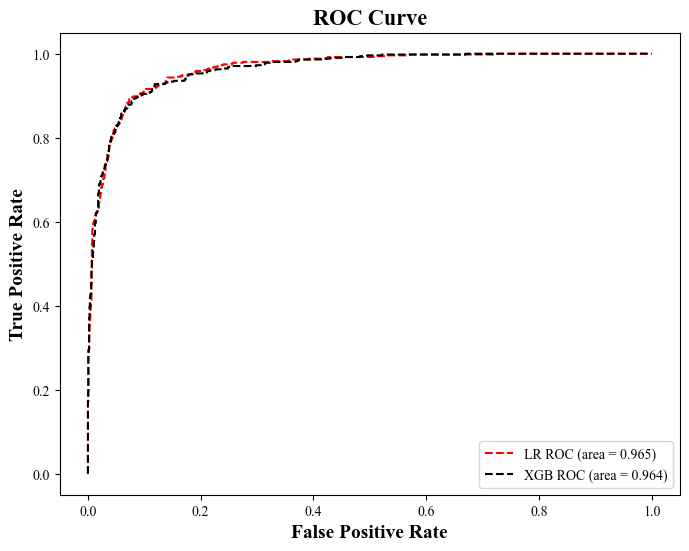

In [12]:

df_train_proba = pd.read_csv('results/X_train_proba_0107.csv', index_col=0)
df_test_proba= pd.read_csv('results/X_test_proba_0107.csv', index_col=0)
def featurelabels(opt, df_train=df_train_proba, df_test=df_test_proba):

    X_train, X_test, y_train, y_test = df_train[opt], df_test[opt], df_train['label'], df_test['label'],

    X_train = np.array(X_train.values)
    X_test = np.array(X_test.values)
    y_train = np.array(y_train.values, dtype=int)
    y_test = np.array(y_test.values, dtype=int)
    return X_train, X_test, y_train, y_test

gapen_descri_list = [['xgb_gapen', 'xgb_descri'], ['lgbm_gapen', 'lgbm_descri']]
gapen_descri_namelist = ['xgb_all', 'lgbm_all']

def all_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    MCC = (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    return MCC, Sn, Sp
def pickle_model_test(clf_str, X_test, y_test):
    
    with open(clf_str+'.pkl', 'rb') as f:
        clf = pickle.load(f)
    # test_all_proba = clf.predict_proba(X_test)
    # test_all_proba = np.array(test_all_proba[:,1]).flatten()
    y_test_pred = clf.predict(X_test)
    y_test_probas = clf.predict_proba(X_test)
    y_test_probas = y_test_probas[:, 1]
    acc = metrics.accuracy_score(y_test, y_test_pred)
    ba = metrics.balanced_accuracy_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_probas)
    mcc, sn, sp = all_scores(y_test,y_test_pred)
    scores = {'test_acc':acc, 'test_ba':ba, 'test_f1':f1, 'test_auc':auc,
              'test_mcc':mcc, 'test_sn':sn, 'test_sp':sp}
    print(scores)
    return y_test_probas
X_train, X_test, y_train, y_test = featurelabels(gapen_descri_list[0])
X_test_w_xgb_descri = np.load('data/X_test_w_xgb_descri.npy')
lr_xgb_test = pickle_model_test('models/XGB_LR', X_test, y_test)
xgb_select_des = pickle_model_test('models/xgb_des', X_test_w_xgb_descri, y_test)
y_test = df_test_proba['label']
fpr, tpr, thersholds = roc_curve(y_test, lr_xgb_test)
fpr_xgb, tpr_xgb, thersholds_xgb = roc_curve(y_test, xgb_select_des)
roc_auc = auc(fpr, tpr)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(fpr, tpr, 'r--', label='LR ROC (area = {0:.3f})'.format(roc_auc))
plt.plot(fpr_xgb, tpr_xgb, 'k--', label='XGB ROC (area = {0:.3f})'.format(roc_auc_xgb ))
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontdict=font2)
plt.ylabel('True Positive Rate', fontdict=font2)
plt.title('ROC Curve', fontdict=font )
plt.legend(loc="lower right")
plt.savefig('stacking后ROC.tif', dpi = 400)
plt.show()

In [42]:
df_LR.iloc[0,:].drop('test_auc')

test_acc    0.916581
test_ba     0.908841
test_f1     0.848654
test_mcc    0.793098
test_sn     0.892578
test_sp     0.925104
Name: xgb_all, dtype: float64

In [48]:
XGB_m_after[[0,1,2,4,5,6]]

array([0.91760491, 0.89945741, 0.84563758, 0.78971134, 0.86132812,
       0.93758668])

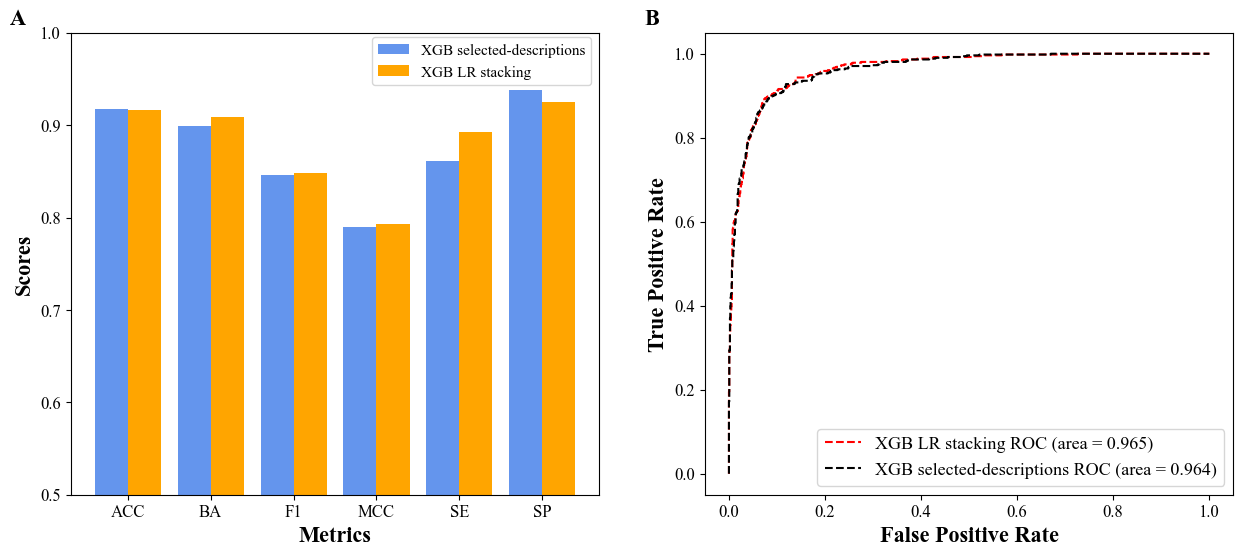

In [15]:
labels = ['ACC', 'BA', 'F1', 'MCC', 'SE', 'SP']
x=np.arange(len(labels))
plt.rcParams['figure.figsize'] = (15, 6)
fig,(ax1, ax2)  = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# LGBM_m_before, XGB_m_before = metrics_before_after(df_test_merics, 'descri')
_, XGB_m_after= metrics_before_after(df_afterselect, 'descri_w')
XGB_m_stacking= df_LR.iloc[0,:].drop('test_auc') 

ax1.set_title('A',fontdict=font,x=-0.1)
ax1.bar(x-0.2, XGB_m_after[[0,1,2,4,5,6]], width, label='XGB selected-descriptions' , color =['cornflowerblue'])
ax1.bar(x+0.2, XGB_m_stacking, width, label='XGB LR stacking', color =['orange']) #'forestgreen'
ax1.tick_params(axis='x', labelsize= 12)
ax1.tick_params(axis='y', labelsize= 12)
ax1.set_xlabel('Metrics', fontdict = font)
ax1.set_ylabel('Scores', fontdict = font)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0.5)
ax1.set_yticks([0.5, 0.6, 0.7, 0.8,0.9,1.0])
ax1.legend(bbox_to_anchor=(0.57, 0.99), loc=2, borderaxespad=0, prop={'size':11})


ax2.set_title('B',fontdict=font,x=-0.1)
ax2.plot(fpr, tpr, 'r--', label='XGB LR stacking ROC (area = {0:.3f})'.format(roc_auc))
ax2.plot(fpr_xgb, tpr_xgb, 'k--', label='XGB selected-descriptions ROC (area = {0:.3f})'.format(roc_auc_xgb ))
ax2.tick_params(axis='x', labelsize= 12)
ax2.tick_params(axis='y', labelsize= 12)
ax2.set_xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('False Positive Rate', fontdict=font)
ax2.set_ylabel('True Positive Rate', fontdict=font)
ax2.legend(loc="lower right", prop={'size':13})
plt.savefig('stacking后性能.tif', dpi = 400)
plt.show()